# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

# Load Data and Data Cleaning

In [2]:
df = pd.read_csv('..\datasets\cleaned_data.csv', index_col='id')

C:\Users\hammi\AppData\Local\Temp\ipykernel_28604\3775944098.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('..\datasets\cleaned_data.csv', index_col='id')


In [3]:
df.columns[43]

'Latitude'

In [4]:
df['Latitude']= df['Latitude'].astype(float)

The data has been clean in the EDA in 01_EDA_and_Cleaning

# Model Prep: Creating features matrix and target vector

## Preprocessing

Initial model 1 features: `floor_area_sqm`, `planning_area`, `block_type`

Initial model 2 features: `full_flat_type`, `planning_area`, `block_type`

In [5]:
X_1 = df[['floor_area_sqm', 'planning_area', 'block_type']]
X_2 = df[['full_flat_type', 'planning_area', 'block_type']]
y = df['resale_price']*100_000

Since `full_flat_type`, `planning_area`, and `block_type` are categorical, we'll dummify the features.

In [6]:
for feature in ['planning_area', 'block_type']:
    X_1 = pd.get_dummies(columns=[feature], drop_first = True, data=X_1)

for feature in ['full_flat_type', 'planning_area', 'block_type']:
    X_2 = pd.get_dummies(columns=[feature], data=X_2)

In [7]:
X_2 = X_2.drop(columns=['full_flat_type_4 ROOM Standard', 'planning_area_Ang Mo Kio'])

Note that the features dropped were `Ang Mo Kio` in planning area and `mixed` in block type.

For X_2, `4 ROOM Standard` was dropped.

# Model Prep: Train/Test split

Since our training set is large, we will use 0.8 of the data as our training size.

In [8]:
X_1_train, X_1_test, y_train, y_test = train_test_split(X_1,y, random_state = 42, train_size=.8)
X_2_train, X_2_test, y_train, y_test = train_test_split(X_2,y, random_state = 42, train_size=.8)

We will use the same random_state to make both models comparable.

We will also standardize `floor_area_sqm` for lasso and ridge in X_1.

In [9]:
ss = StandardScaler()
ss.fit(X_1_train)
X_1_train = ss.transform(X_1_train)
X_1_test = ss.transform(X_1_test)

# Instantiate models

In [10]:
lr = LinearRegression()

In [11]:
optimal_lasso = LassoCV(n_alphas = 500, max_iter=2000)

In [12]:
optimal_ridge = RidgeCV(alphas = np.linspace(.1, 10, 100))

In [13]:
null_model = np.full(shape=len(y), fill_value=y.mean())

Our null model will be the mean resale price.

# X_1 Cross Validation

We'll see which version of the X_1 model to use. We'll use RMSE (i.e. closer to 0, better fit)

In [14]:
# Null model
np.sqrt(mean_squared_error(y,null_model))

143212.05306422437

In [15]:
lr_scores_rmse = -cross_val_score(lr,X_1_train,y_train, scoring = 'neg_root_mean_squared_error')
lr_scores_rmse.mean()

80467.66427395512

In [16]:
lasso_scores_rmse = -cross_val_score(optimal_lasso,X_1_train,y_train, scoring = 'neg_root_mean_squared_error')
lasso_scores_rmse.mean()

80472.48697005266

In [17]:
ridge_scores_rmse = -cross_val_score(optimal_ridge,X_1_train,y_train, scoring = 'neg_root_mean_squared_error')
ridge_scores_rmse.mean()

80467.66473180144

All our regression models for X_1 features turned out really well relative to the null model.

We will now see how it performs for overfitting.

In [18]:
optimal_lasso.fit(X_1_train,y_train);

In [19]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_1_train,y_train)

Lasso(alpha=94.07044759685141)

In [20]:
lasso_train_rmse = -cross_val_score(lasso,X_1_train,y_train, scoring = 'neg_root_mean_squared_error')
lasso_test_rmse = -cross_val_score(lasso,X_1_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {lasso_train_rmse.mean()}, Test RMSE = {lasso_test_rmse.mean()}')

Train RMSE = 80472.49381616733, Test RMSE = 80258.56905455836


In [21]:
optimal_ridge.fit(X_1_train,y_train);

In [22]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge.fit(X_1_train,y_train)

Ridge(alpha=4.8)

In [23]:
ridge_train_rmse = -cross_val_score(ridge,X_1_train,y_train, scoring = 'neg_root_mean_squared_error')
ridge_test_rmse = -cross_val_score(ridge,X_1_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {ridge_train_rmse.mean()}, Test RMSE = {ridge_test_rmse.mean()}')

Train RMSE = 80467.66514525529, Test RMSE = 80254.97943726253


There is minimal overfitting as expected.

Let's check out how linear regression compares to ridge.

In [24]:
lr_train_rmse = -cross_val_score(lr,X_1_train,y_train, scoring = 'neg_root_mean_squared_error')
lr_test_rmse = -cross_val_score(lr,X_1_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {lr_train_rmse.mean()}, Test RMSE = {lr_test_rmse.mean()}')

Train RMSE = 80467.66427395512, Test RMSE = 80255.00564688398


We have very similar results.

# X_1 coef distribution

## Linear Regression features

In [25]:
lr.fit(X_1_train,y_train)

LinearRegression()

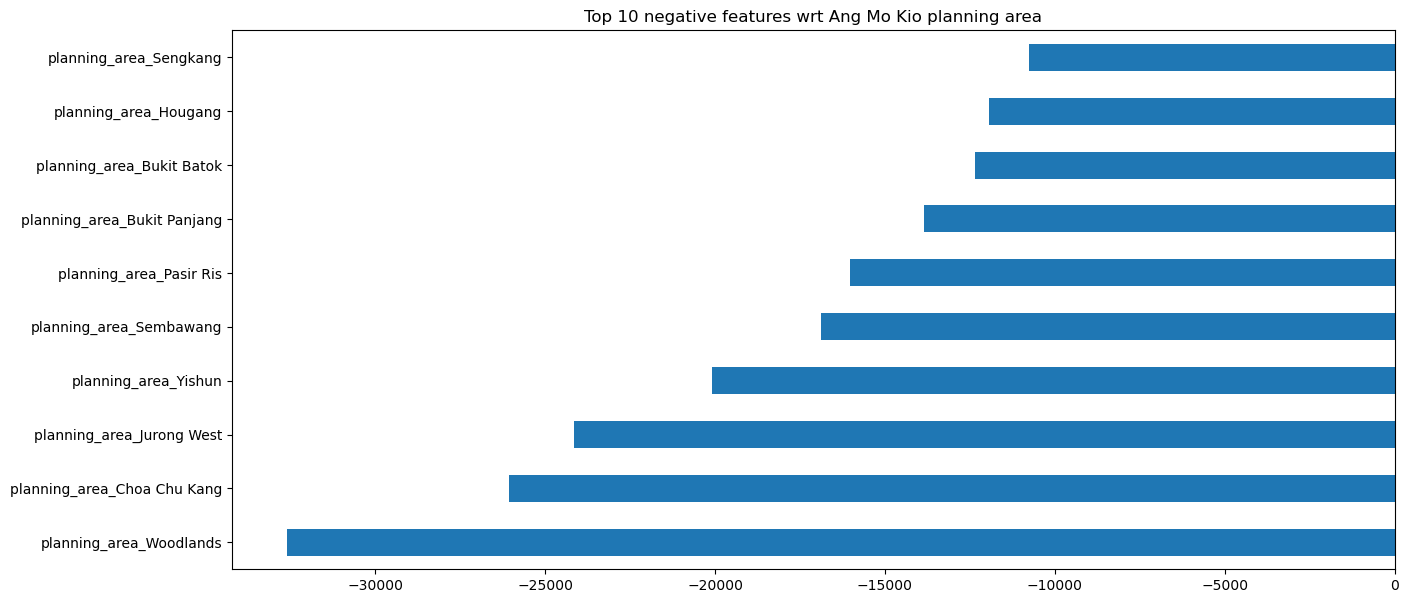

In [26]:
plt.title('Top 10 negative features wrt Ang Mo Kio planning area')

lr_top_neg = pd.Series(lr.coef_, index = X_1.columns).sort_values(ascending=True)[:10]

lr_top_neg.plot(kind = 'barh', figsize=(15,7))
    
plt.show()

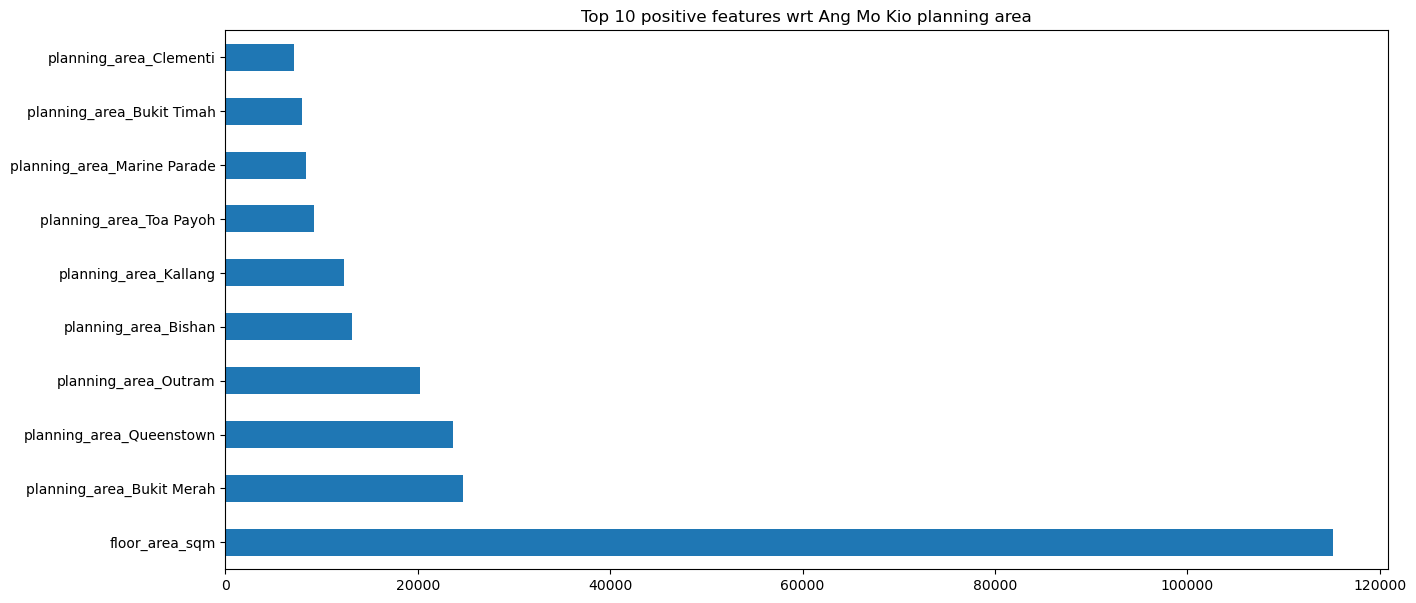

In [27]:
plt.title('Top 10 positive features wrt Ang Mo Kio planning area')

lr_top_pos = pd.Series(lr.coef_, index = X_1.columns).sort_values(ascending=False)[:10]

lr_top_pos.plot(kind = 'barh', figsize=(15,7))
plt.show()

---

## Lasso Features 

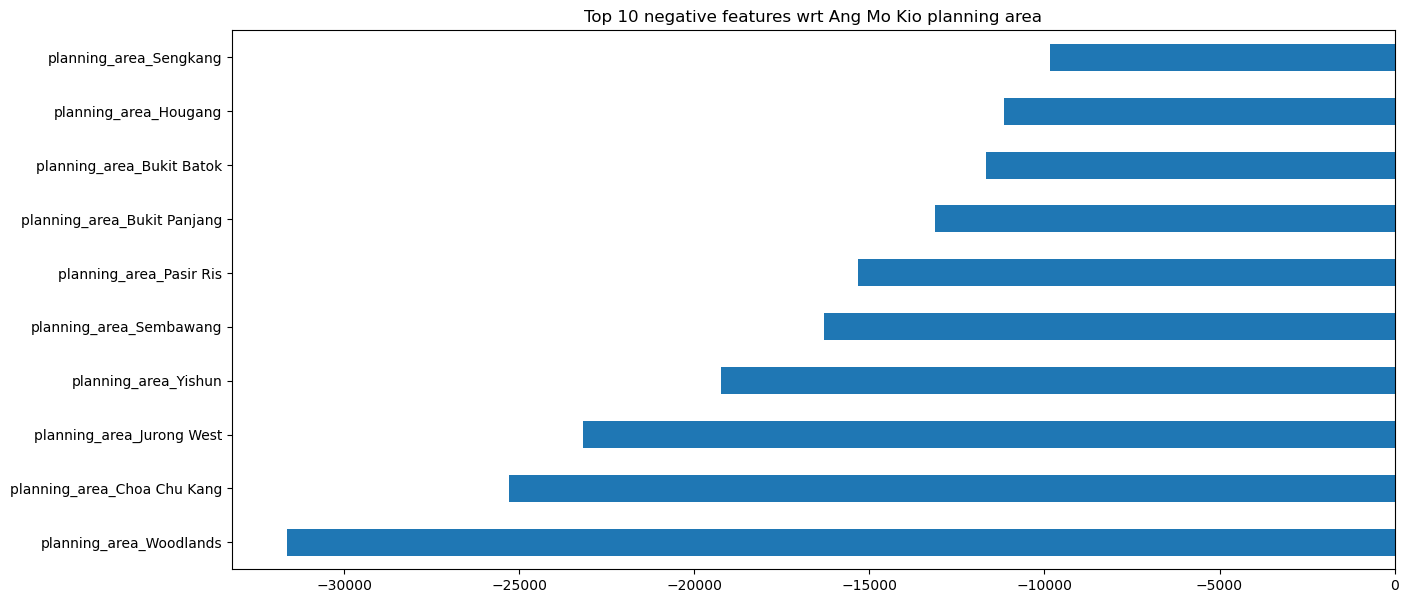

In [28]:
plt.title('Top 10 negative features wrt Ang Mo Kio planning area')

lasso_top_neg = pd.Series(lasso.coef_, index = X_1.columns).sort_values(ascending=True)[:10]

lasso_top_neg.plot(kind = 'barh', figsize=(15,7))
plt.show()

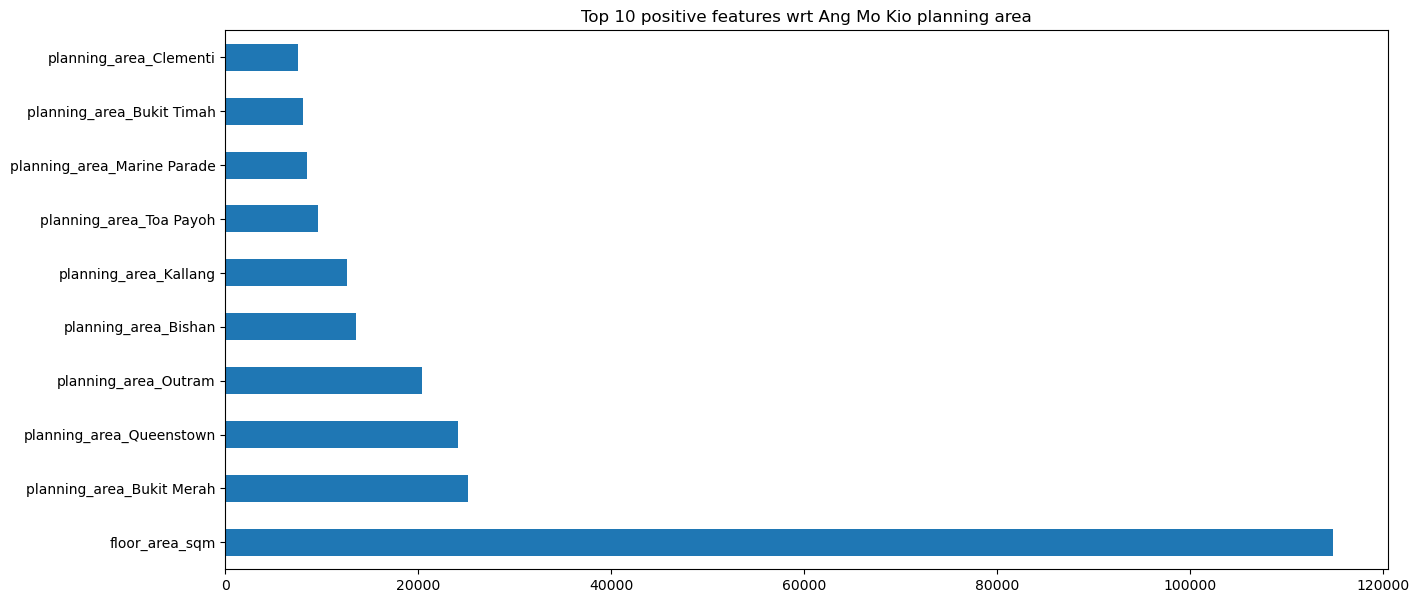

In [29]:
plt.title('Top 10 positive features wrt Ang Mo Kio planning area')

lasso_top_pos = pd.Series(lasso.coef_, index = X_1.columns).sort_values(ascending=False)[:10]
lasso_top_pos.plot(kind = 'barh', figsize=(15,7))

plt.show()

---

## Ridge Features 

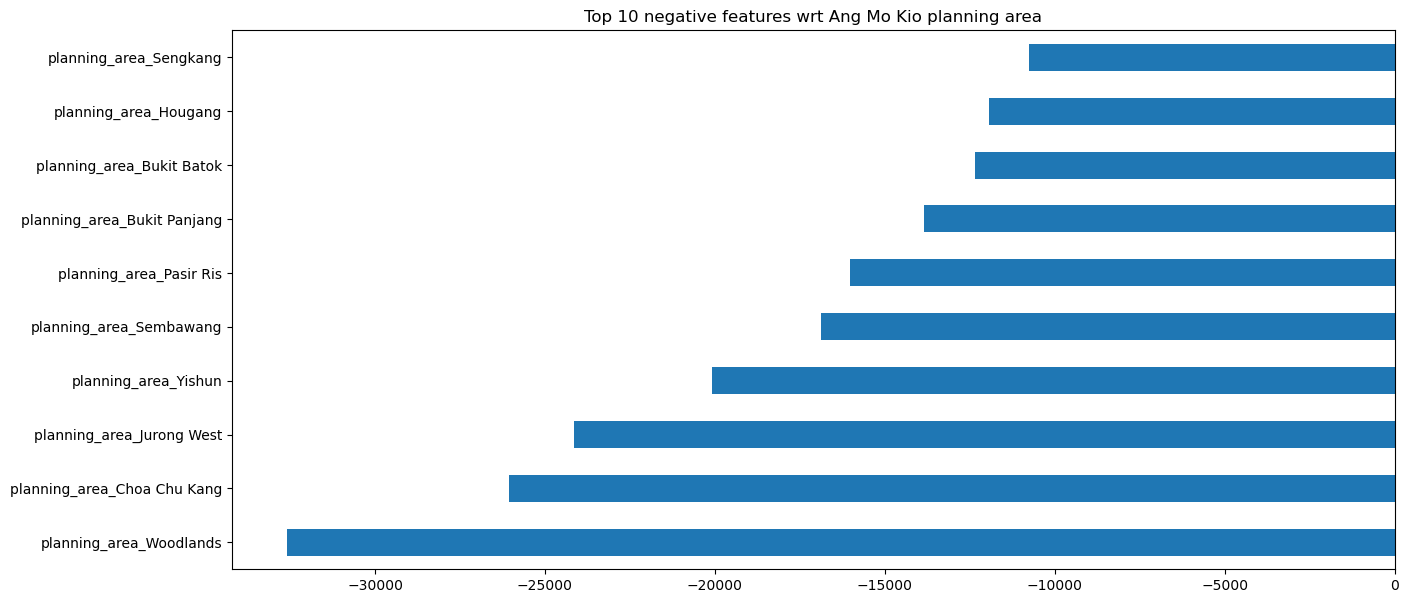

In [30]:
plt.title('Top 10 negative features wrt Ang Mo Kio planning area')

ridge_top_neg = pd.Series(ridge.coef_, index = X_1.columns).sort_values(ascending=True)[:10]
ridge_top_neg.plot(kind = 'barh', figsize=(15,7))

plt.show()

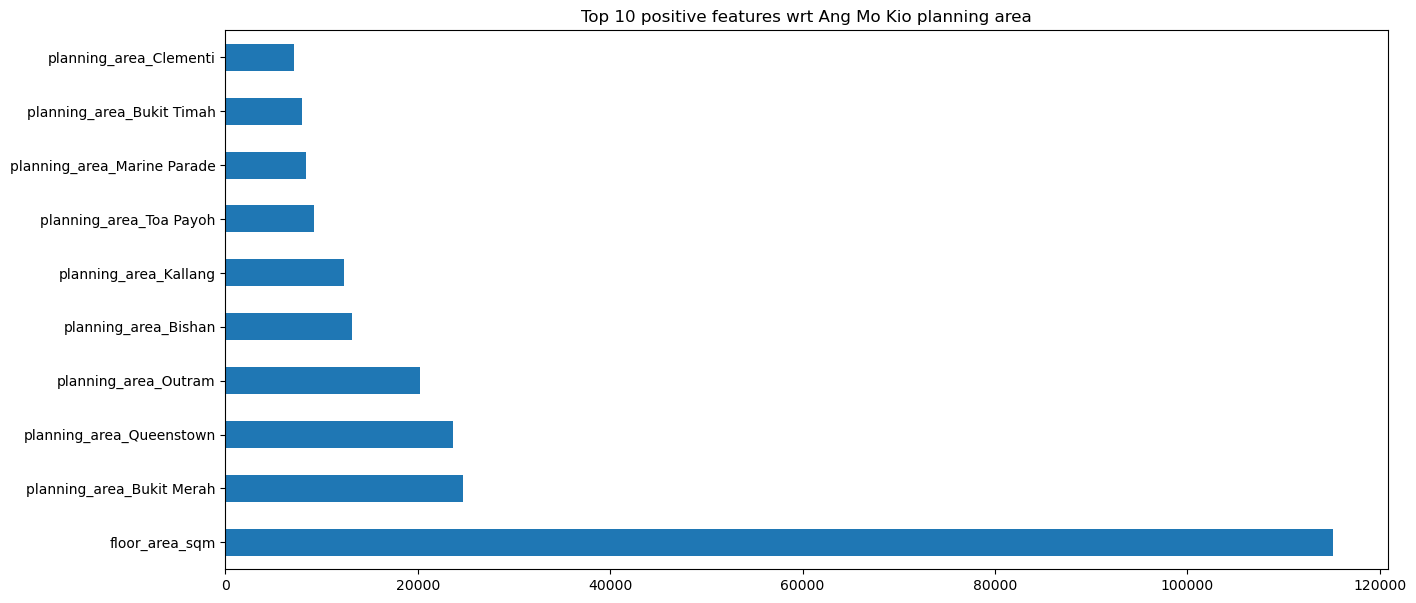

In [31]:
plt.title('Top 10 positive features wrt Ang Mo Kio planning area')

ridge_top_pos = pd.Series(ridge.coef_, index = X_1.columns).sort_values(ascending=False)[:10]
ridge_top_pos.plot(kind = 'barh', figsize=(15,7))

plt.show()

In [32]:
pred = ridge.predict(X_1_test)

In [33]:
residual = y_test - pred

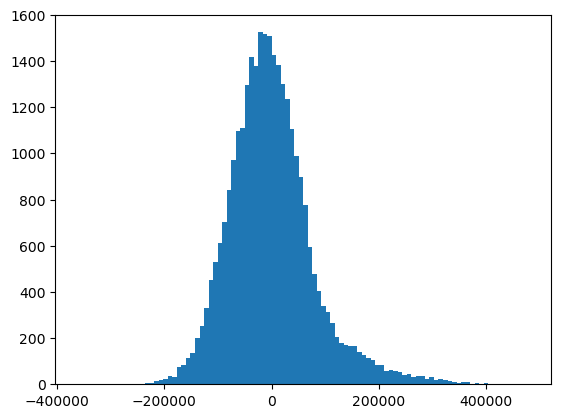

In [34]:
plt.hist(residual,bins=100)
plt.show()

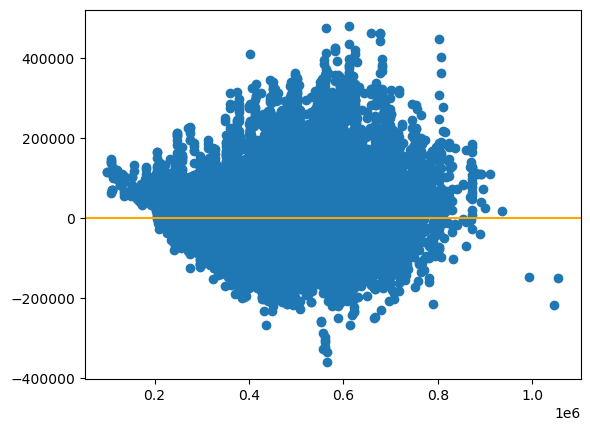

In [35]:
plt.scatter(x=pred, y=residual)
plt.axhline(0,color='orange')
plt.show()

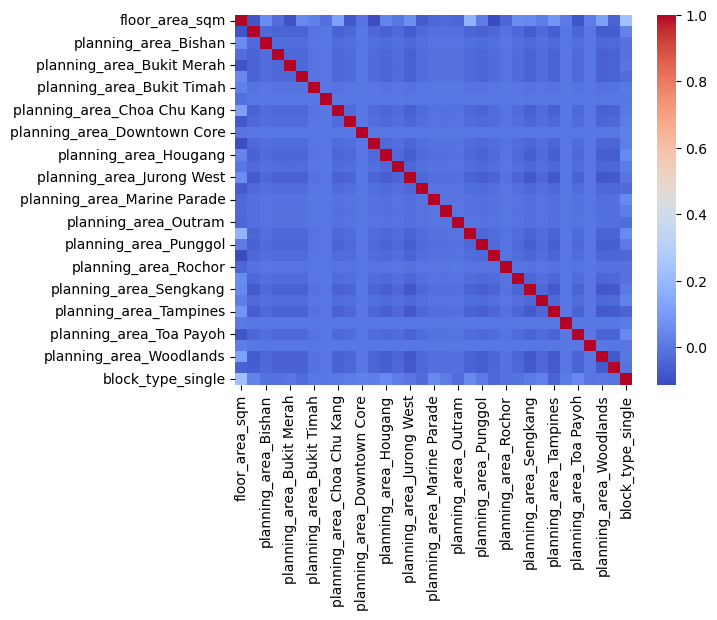

In [36]:
sns.heatmap(X_1.corr(), cmap='coolwarm');

As expected, none of the features a collinear.

# X_2 Cross Validation

We'll see which version of the X_2 model to use. We'll use RMSE (i.e. closer to 0, better fit)

In [37]:
# Null model
np.sqrt(mean_squared_error(y,null_model))

143212.05306422437

In [38]:
lr_scores_rmse = -cross_val_score(lr,X_2_train,y_train, scoring = 'neg_root_mean_squared_error')
lr_scores_rmse.mean()

65518.503139766326

In [39]:
lasso_scores_rmse = -cross_val_score(optimal_lasso,X_2_train,y_train, scoring = 'neg_root_mean_squared_error')
lasso_scores_rmse.mean()

65752.82021395043

In [40]:
ridge_scores_rmse = -cross_val_score(optimal_ridge,X_2_train,y_train, scoring = 'neg_root_mean_squared_error')
ridge_scores_rmse.mean()

65519.18585240016

All our regression models for X_2 features turned out really well relative to the null model.

We will now see how it performs for overfitting.

---

In [41]:
optimal_lasso.fit(X_2_train,y_train);

In [42]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_2_train,y_train)

Lasso(alpha=13.13270852452469)

In [43]:
lasso_train_rmse = -cross_val_score(lasso,X_2_train,y_train, scoring = 'neg_root_mean_squared_error')
lasso_test_rmse = -cross_val_score(lasso,X_2_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {lasso_train_rmse.mean()}, Test RMSE = {lasso_test_rmse.mean()}')

C:\Users\hammi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.754e+11, tolerance: 4.897e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\hammi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.149e+11, tolerance: 4.928e+10
  model = cd_fast.enet_coordinate_descent(


Train RMSE = 65752.87002283023, Test RMSE = 65630.42629409053


C:\Users\hammi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.100e+11, tolerance: 4.820e+10
  model = cd_fast.enet_coordinate_descent(


In [44]:
optimal_ridge.fit(X_2_train,y_train);

In [45]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge.fit(X_2_train,y_train)

Ridge(alpha=0.1)

In [46]:
ridge_train_rmse = -cross_val_score(ridge,X_2_train,y_train, scoring = 'neg_root_mean_squared_error')
ridge_test_rmse = -cross_val_score(ridge,X_2_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {ridge_train_rmse.mean()}, Test RMSE = {ridge_test_rmse.mean()}')

Train RMSE = 65519.18585224131, Test RMSE = 65239.21570223335


There is minimal overfitting as expected.

Let's check out how linear regression compares to ridge.

In [47]:
lr_train_rmse = -cross_val_score(lr,X_2_train,y_train, scoring = 'neg_root_mean_squared_error')
lr_test_rmse = -cross_val_score(lr,X_2_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {lr_train_rmse.mean()}, Test RMSE = {lr_test_rmse.mean()}')

Train RMSE = 65518.503139766326, Test RMSE = 65213.062977502224


We have very similar results.

# X_2 coef distribution

## Linear Regression features

In [48]:
lr.fit(X_2_train,y_train)

LinearRegression()

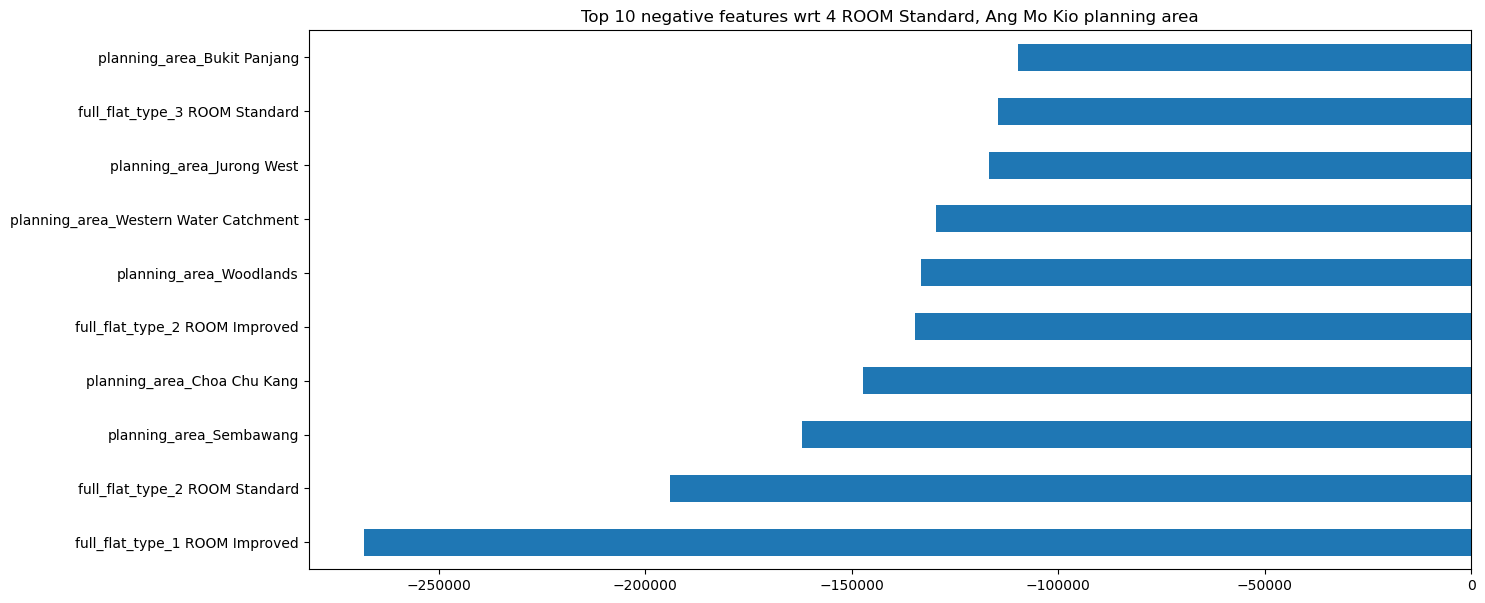

In [49]:
plt.title('Top 10 negative features wrt 4 ROOM Standard, Ang Mo Kio planning area')

(pd.Series(lr.coef_, index = X_2.columns)
 .sort_values(ascending=True)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

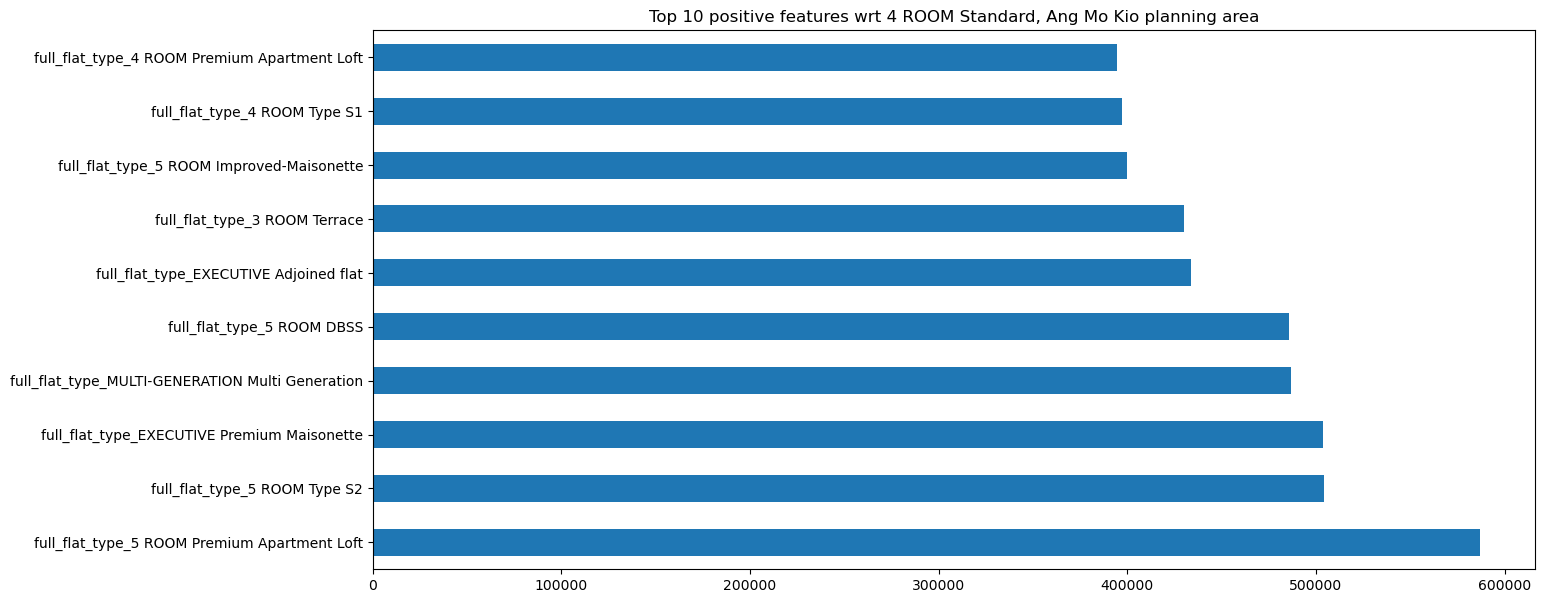

In [50]:
plt.title('Top 10 positive features wrt 4 ROOM Standard, Ang Mo Kio planning area')

(pd.Series(lr.coef_, index = X_2.columns)
 .sort_values(ascending=False)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

---

## Lasso Features 

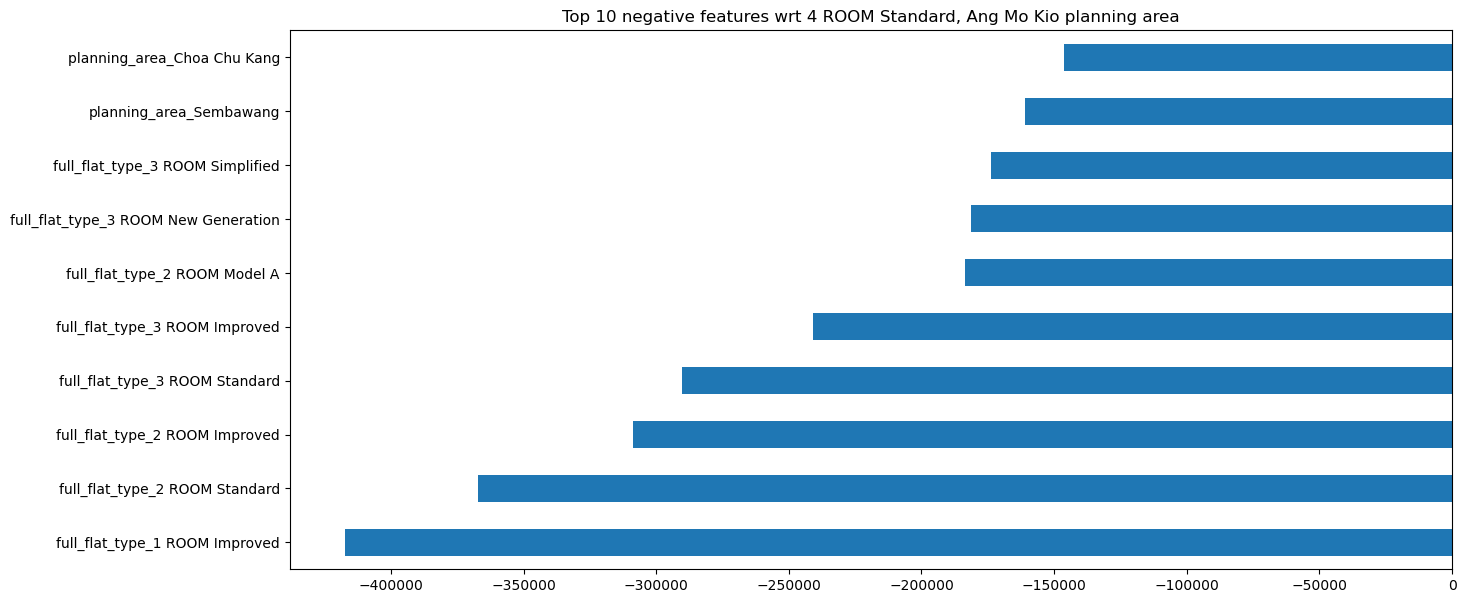

In [51]:
plt.title('Top 10 negative features wrt 4 ROOM Standard, Ang Mo Kio planning area')

(pd.Series(lasso.coef_, index = X_2.columns)
 .sort_values(ascending=True)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

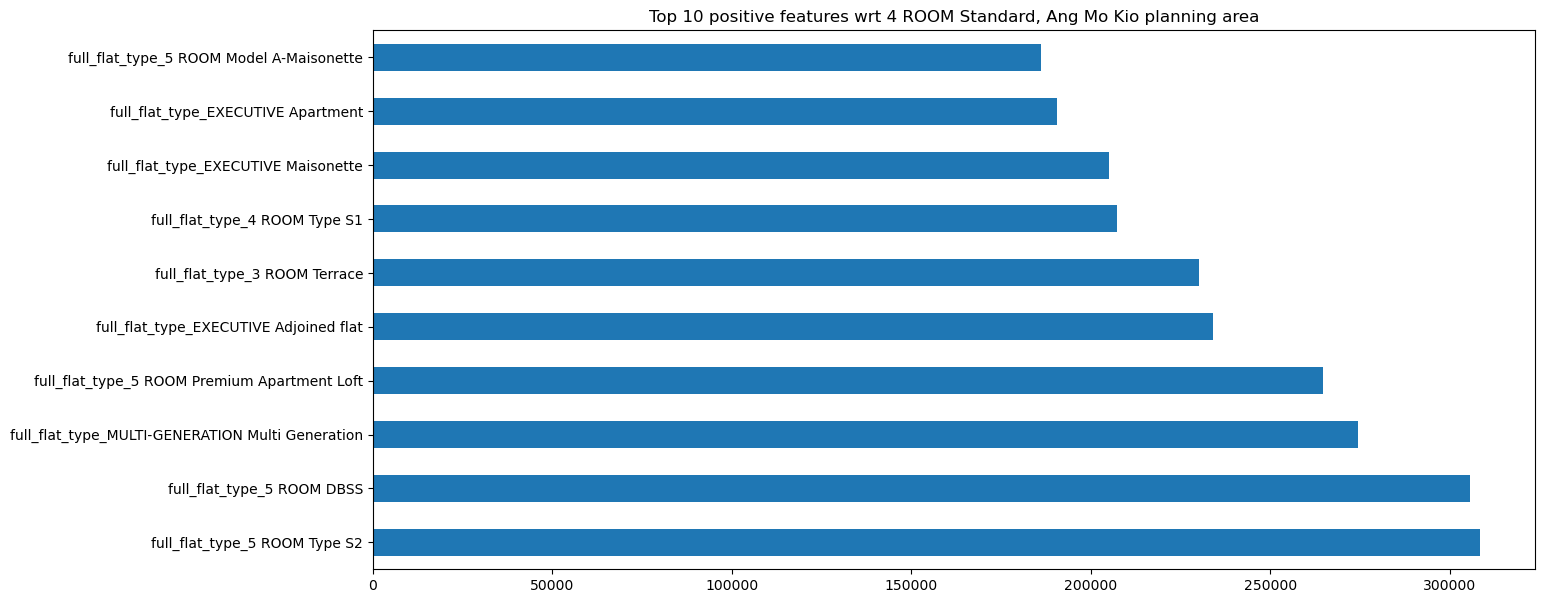

In [52]:
plt.title('Top 10 positive features wrt 4 ROOM Standard, Ang Mo Kio planning area')

(pd.Series(lasso.coef_, index = X_2.columns)
 .sort_values(ascending=False)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

---

## Ridge Features 

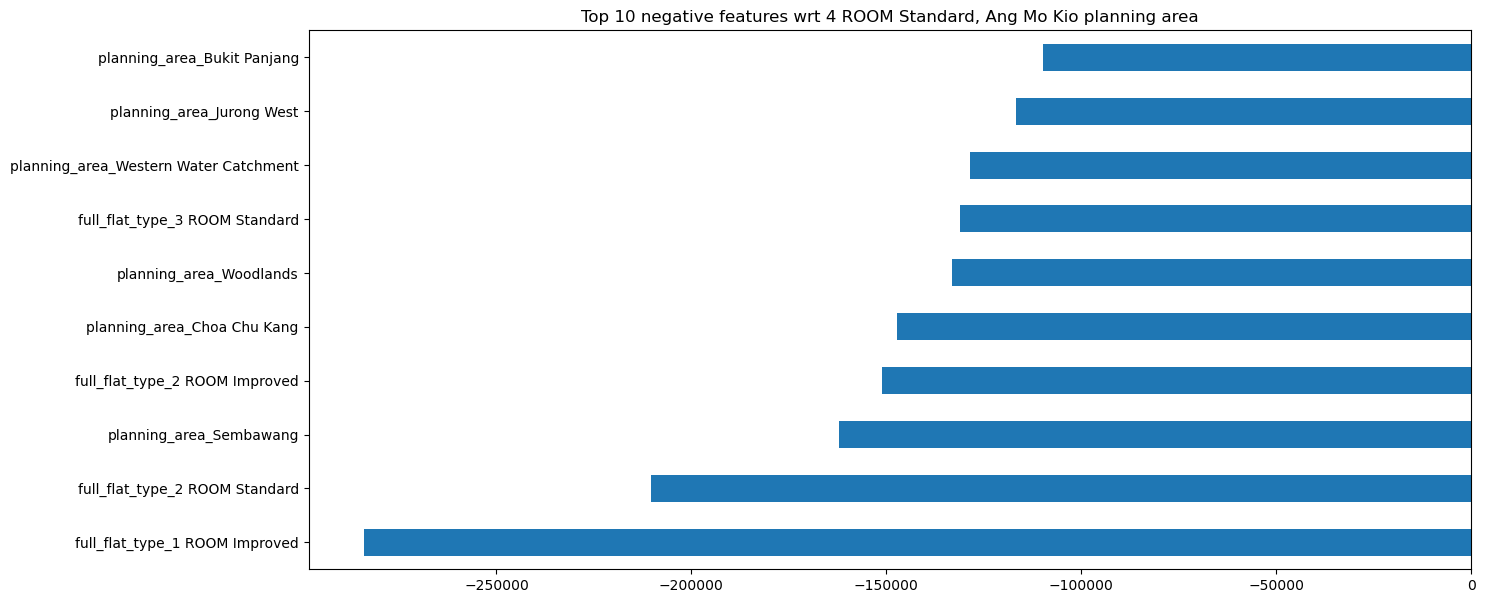

In [53]:
plt.title('Top 10 negative features wrt 4 ROOM Standard, Ang Mo Kio planning area')

(pd.Series(ridge.coef_, index = X_2.columns)
 .sort_values(ascending=True)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

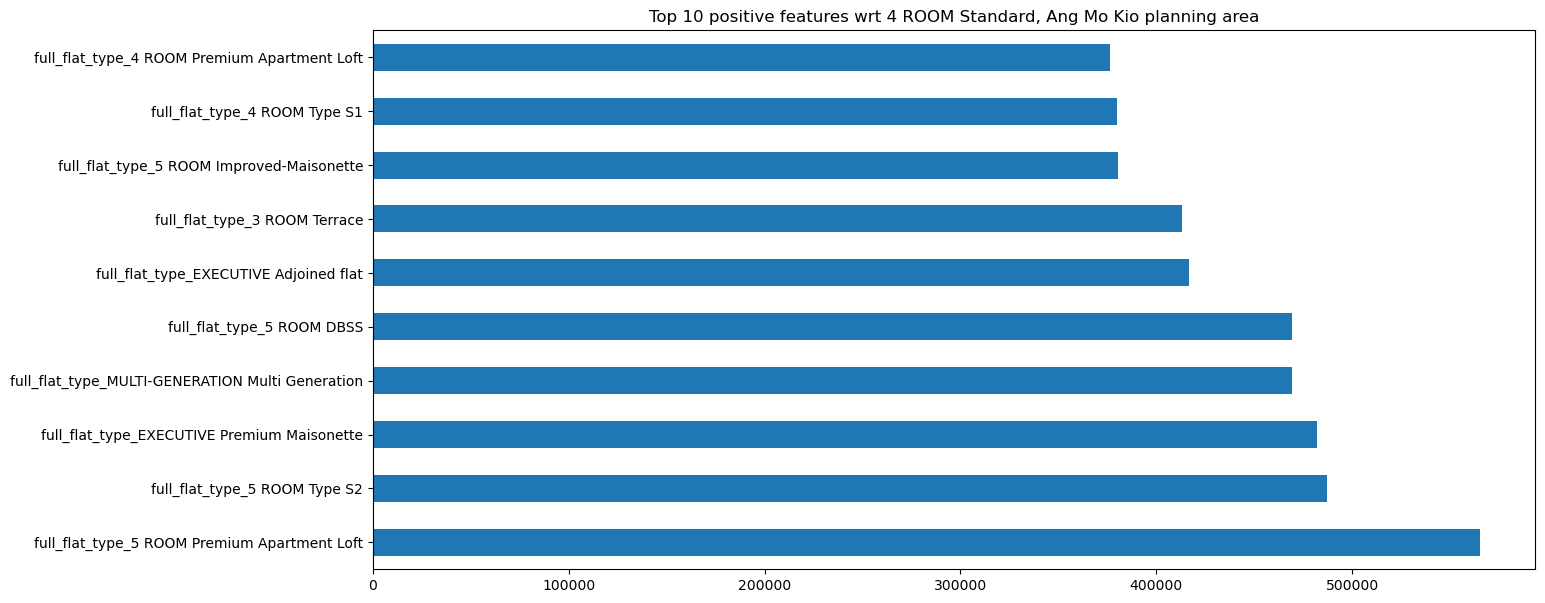

In [54]:
plt.title('Top 10 positive features wrt 4 ROOM Standard, Ang Mo Kio planning area')

(pd.Series(ridge.coef_, index = X_2.columns)
 .sort_values(ascending=False)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

In [55]:
pred = ridge.predict(X_2_test)

In [56]:
residual = y_test - pred

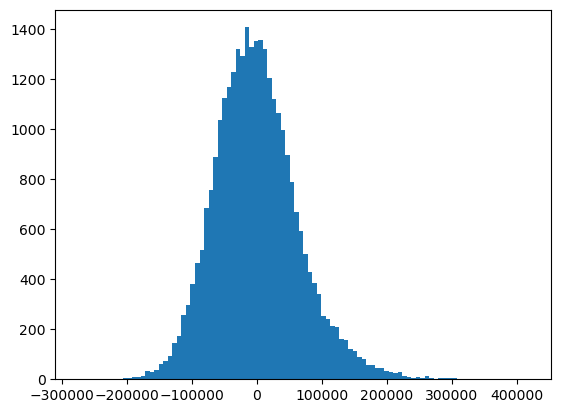

In [57]:
plt.hist(residual,bins=100)
plt.show()

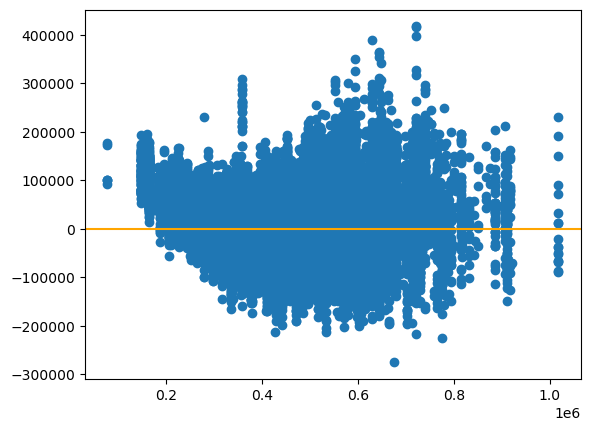

In [58]:
plt.scatter(x=pred, y=residual)
plt.axhline(0,color='orange')
plt.show()

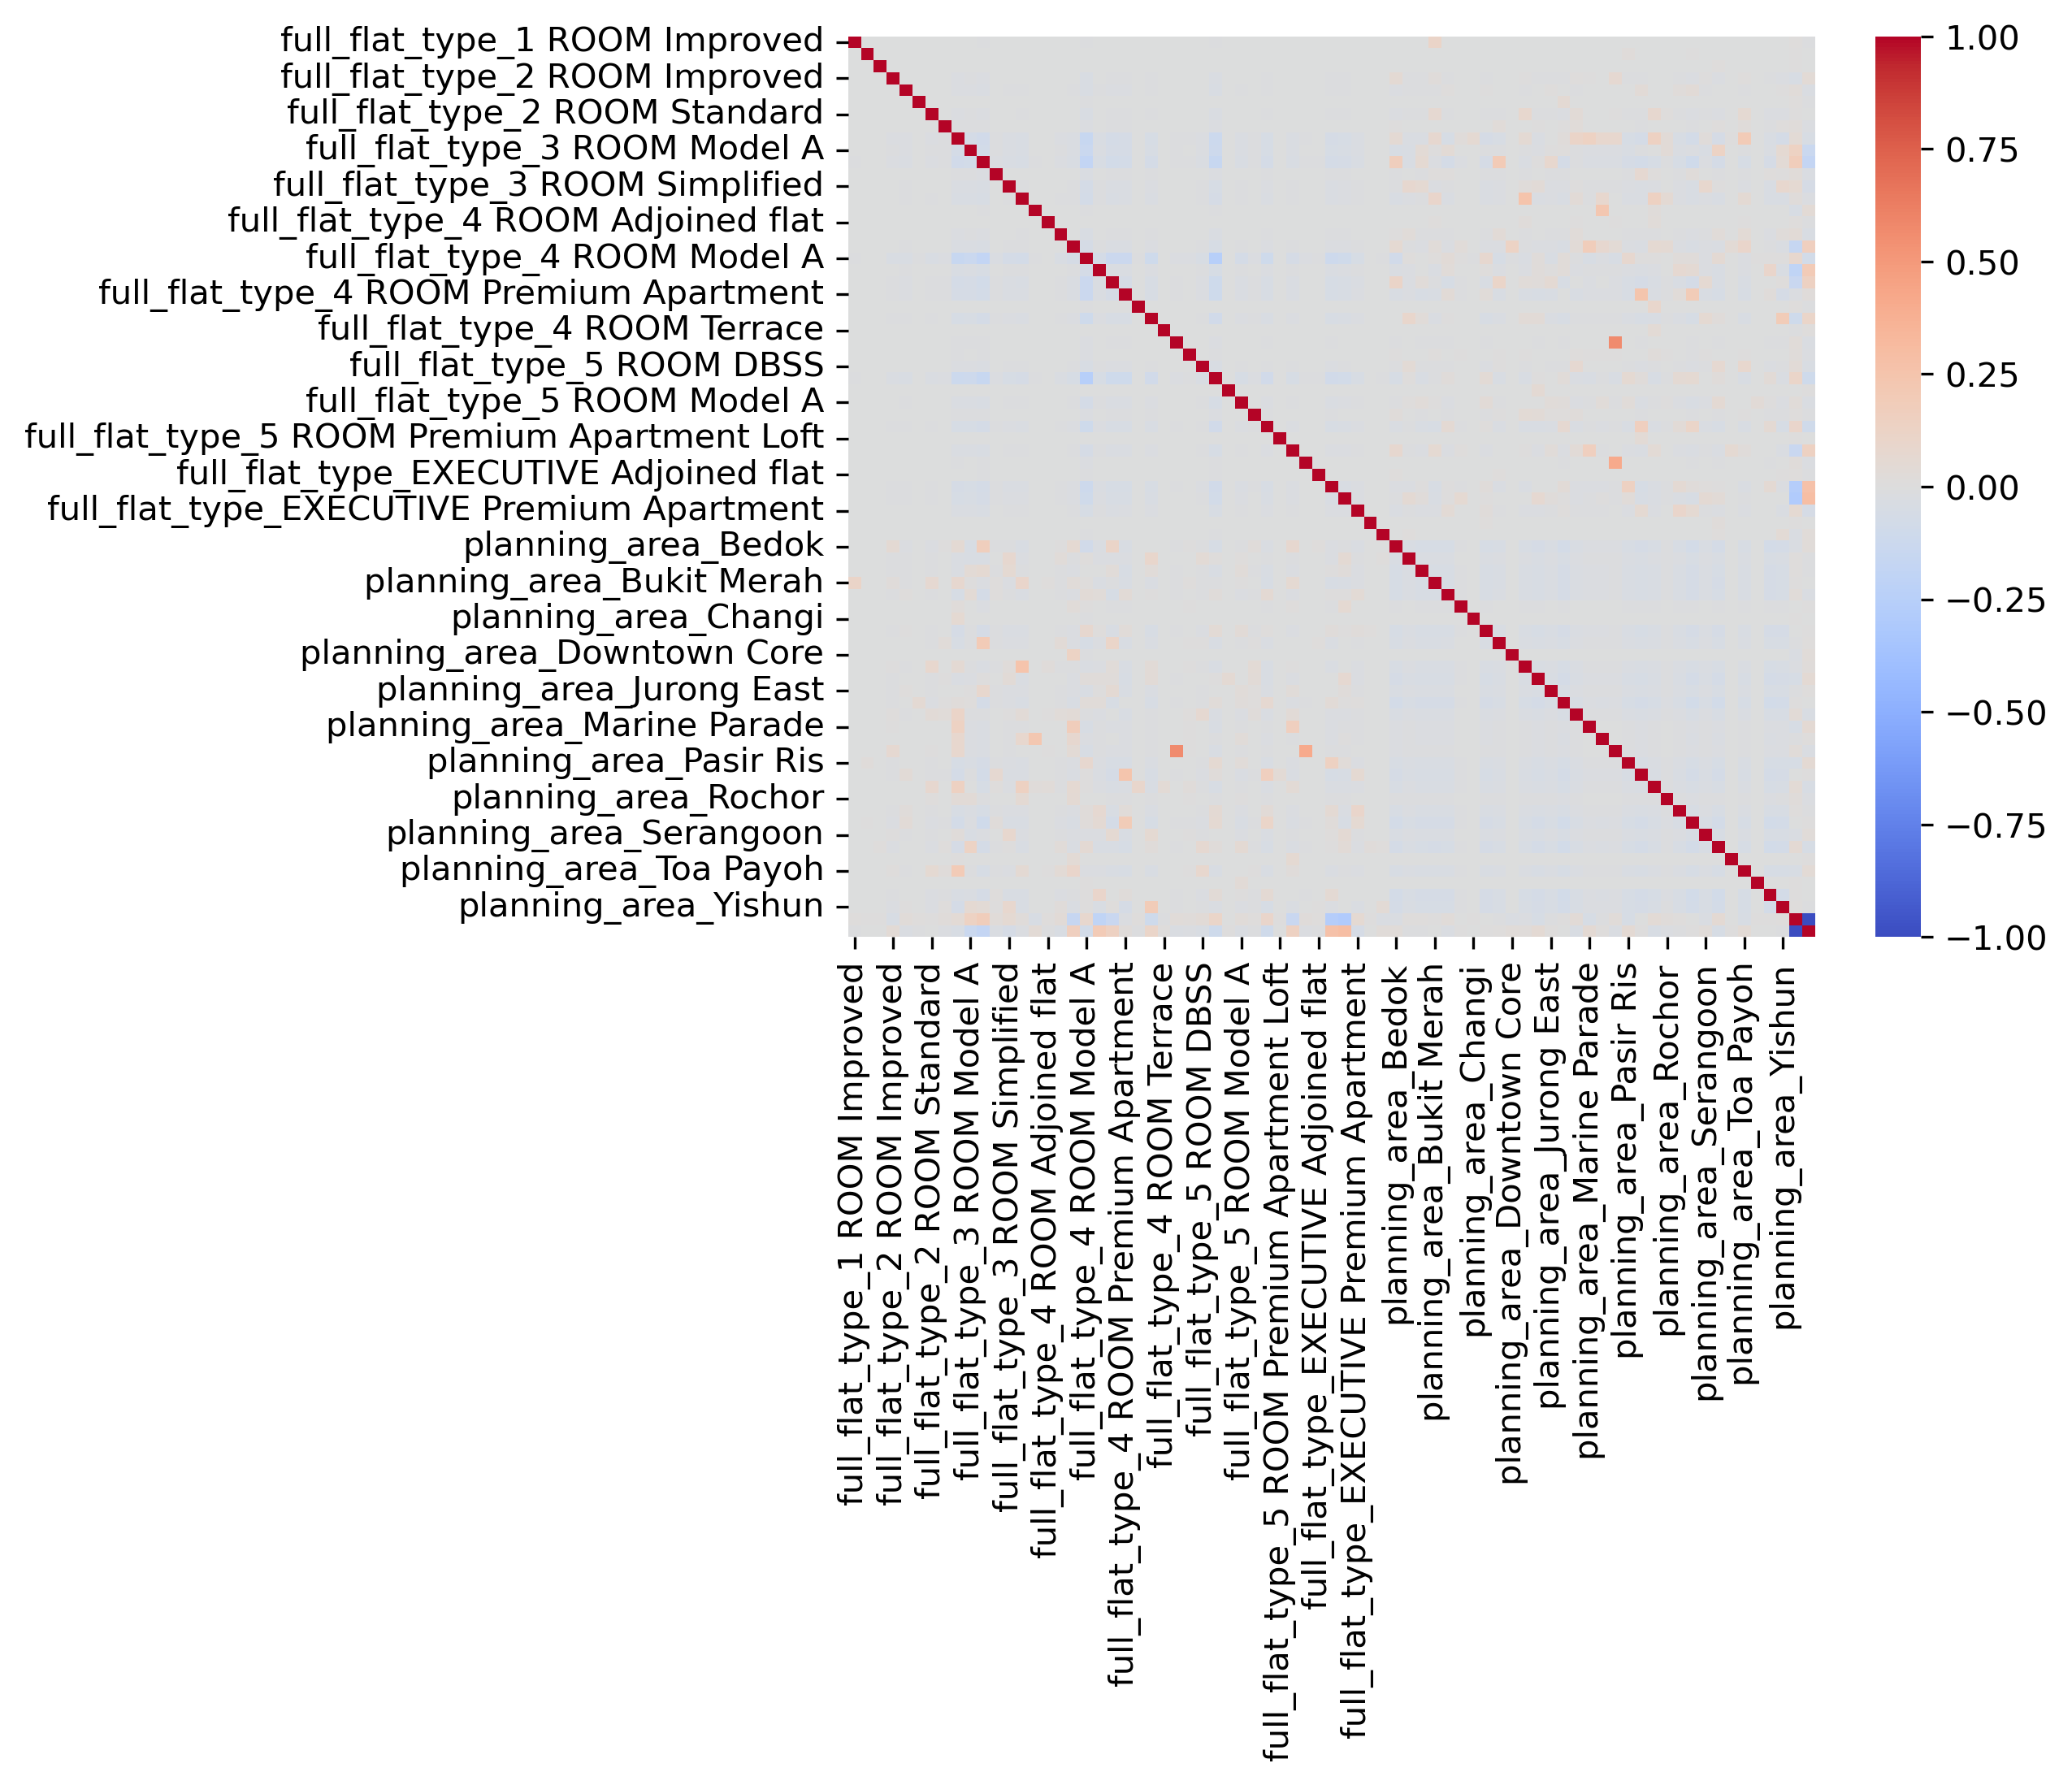

In [59]:
plt.figure(dpi=300)
sns.heatmap(X_2.corr(), cmap='coolwarm');

Pasir Ris seem to correlate with 4 ROOM Terrace and EXCECUTIVE Adjoined flat.

It may be because Pasir Ris is the only planning area that has those flat type and model combinations.

# First Kaggle Submission

We can see that the second initial model does very well in predicting the resale values.

We will now generate predictions on the validation set and submit it in Kaggle.

In [60]:
df_validation = pd.read_csv(r'..\datasets\test.csv')

C:\Users\hammi\AppData\Local\Temp\ipykernel_28604\138062426.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_validation = pd.read_csv(r'..\datasets\test.csv')


In [61]:
df_validation.columns[41]

'postal'

Since we're not using postal, we can skip this step.

In [62]:
df_validation['block_type']=np.nan

def block_sorter(row):
    type_count=0
    hdb_types = ['1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold']
    for hdb_type in hdb_types:
        if row[hdb_type]!=0:
            type_count+=1
    if type_count==1:
        row['block_type']='single'
    if type_count>1:
        row['block_type']='mixed'
    return row

df_validation = df_validation.apply(block_sorter, axis = 1)

In [63]:
X_train = df[['full_flat_type', 'planning_area', 'block_type']] #We'll be using the full training dataset.
X_validation = df_validation[['full_flat_type', 'planning_area', 'block_type']]

y_train = df['resale_price']

In [64]:
for feature in ['full_flat_type', 'planning_area', 'block_type']:
    X_train = pd.get_dummies(columns=[feature], drop_first = True, data=X_train)

for feature in ['full_flat_type', 'planning_area', 'block_type']:
    X_validation = pd.get_dummies(columns=[feature], drop_first = True, data=X_validation)

In [65]:
X_train.shape

(149805, 74)

In [66]:
X_validation.shape

(16737, 71)

In [67]:
missing_columns = X_train.columns.difference(X_validation.columns).tolist()

We will add those columns in to X_validation

In [68]:
missing_features = []
for feature in missing_columns:
    missing_features.append((X_train.columns.get_loc(feature),feature))

In [69]:
missing_features

[(0, 'full_flat_type_2 ROOM 2-room'),
 (1, 'full_flat_type_2 ROOM DBSS'),
 (24, 'full_flat_type_4 ROOM Terrace')]

In [70]:
for feature in missing_features:
    X_validation.insert(feature[0], feature[1],0)

In [71]:
X_validation.shape

(16737, 74)

In [72]:
lr = LinearRegression()

In [73]:
lr.fit(X_train, y_train)

LinearRegression()

In [74]:
lr.predict(X_validation)

array([3.30467843, 4.81966661, 3.42919359, ..., 4.46726972, 5.13872282,
       3.99929139])

In [75]:
final_predicts = pd.DataFrame(data=[df_validation['id'],np.transpose(lr.predict(X_validation))], columns=['Id','Predicted'])

In [76]:
final_predicts = pd.DataFrame({'Id':df_validation['id'],'Predicted':lr.predict(X_validation)*100_000})

In [77]:
df_validation['id']

0        114982
1         95653
2         40303
3        109506
4        100149
          ...  
16732     23347
16733     54003
16734    128921
16735     69352
16736    146210
Name: id, Length: 16737, dtype: int64

In [78]:
final_predicts.to_csv(r'..\datasets\predictions.csv', index=False)